**Gwen Templeton's NFL Big Data Bowl 2023**
Exploring spin moves by pass rushers 
Metric track
Thanks to help of my mentors Ethan Douglas & Matthew Reyers

**Introduction**
Pass Rushers have a many different moves to get past their competitor to put pressure on the opposing team's quarterback. 
A Spin Move, though not the most common move, is often a ESPN highlight when it's used to put heat on the the quarterback
this notebook will attempt to use NFL player tracking data to label and explore spin moves and the pressures they create. 


In [ ]:
#load in library
library(tidyverse)
library(gganimate)
library(cowplot)
library(repr)
library(dplyr)
library(caret)
#bring in the data
pff <- read_csv("nfl-big-data-bowl-2023/pffScoutingData.csv")
players <- read_csv("nfl-big-data-bowl-2023/players.csv")
plays <- read_csv("nfl-big-data-bowl-2023/plays.csv")
week<-seq(1,8)
df_tracking<-data.frame()
for(w in week){
  df_tracking_temp <- read_csv(paste0("nfl-big-data-bowl-2023/tracking/week",w,".csv"), col_types = cols())
  df_tracking<-bind_rows(df_tracking_temp, df_tracking) }
df_readRPlays <- read_csv("https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_2021.csv",col_types=cols_only(old_game_id='i', play_id ='i', xpass='d'))
source("https://raw.githubusercontent.com/mlfurman3/gg_field/main/gg_field.R")


#merging all the data together for analysis
players1<-players %>% 
  select(nflId, displayName)
    
#merging all the data together for analysis
totalt<-merge(plays,df_tracking,by=c("gameId","playId"))
totalf<- merge(totalt,pff,all.x=TRUE, by=c("gameId","playId","nflId"))
total_players<-merge(totalf,players1,all.x=TRUE, by="nflId")  



**Method to the madness**

NFL Player tracking data contains location infomation of players with their x, y coordinates aka where the player is on the field, orientation and direction which are Player orientation where motion of player's shoulder pads are facing 0 to 360 degrees player direction Angle of player motion 0 to 360. Using a pass rusher's orientation and angle  of motion as they move agaisnt the offesnive linemen we can approximate based on change of orientation and angle of motion the type of pash rush move used including the spin move. For example a play with a pass rusher going up on x and not much change in motion or orientation we can assume it's more of a straight bull rush on the olinemen. 

For a spin move if we create a change orientation by taking the current frameId's orientation, the 5th previous frameId orientation, and substracking the two.Similary we can do the same with direction.  Now we have the player's movement over 5 frames. 

Now to set boundries to what it means to do a spin move. Orientation is measured as a circle so 10 degrees and 360 degrees is only 20 degree change.So that is kept in mind by max change in orientation of 300. In order for a player to do a complete spin a players shoulders and body will change orientation at a estimation of at least over 250 degrees So we will go little over with 260 in order to make sure spin is done, 180 could be an indicator but also doesn't fully tell if a player went all away with their spin or if they stopped. 

In order to try to take in account defender running past a QB and turning back into them like a spin, a limit is placed on change in direction to less then 90 to help combate those incidents 

Next to creat total pressure score by using ifelse function to add up pff pressure stats of pff_hit, pff_hurry, pff_sack


In [ ]:
#creating nappers which creates new columns of the current frameId -5 and snap column representing the 6th frame
#filter it out so we don't get presnap data
nappers <- total_players %>%
  mutate(fm5=frameId-5) %>% mutate(snap=6) %>%
  filter(fm5>=4)

# creating the ability to get the orientation and direction from 5 previous frames so we can do our comparison in player movement
test_lag<- nappers %>%
 group_by(gameId, playId,nflId) %>%
 mutate(lag_frame=lag(o,5),lag_dir=lag(dir,5))

#create new dataframe that has change in orientation and direction, which takes the current one and substract the o or dir from the 5th previous frame
newtestsnap<- test_lag %>% mutate(changeo=abs(o-lag_frame),changedir=dir-lag_dir)


# creating spinmove category classification by using change in o and dir 
# orientation is measured in degrees and is a circle so 10 degrees and 360 degrees is only 20 degree change.So that is kept in mind by max change in orientation of 300. In order for a player to do a complete spin a player shoulders and body
#will change orientation at least over 250 degrees to start making its way around a circle. So we will go little over with 260 in order to make sure spin is done, 180 could be an indicator but also doesn't fully tell if a player went all away with their spin or if they stopped. 
#In order to try to take in account defender running past a QB and turning back into them like a spin, a limit is placed on direction to less then 90 to help combate those incidents
newtestsnap$spinmove<-ifelse(newtestsnap$changeo  >= 260 & newtestsnap$changeo <=300 & newtestsnap$changedir <= 90,1,0)

#filtering our data to just the passrushers
testsnap<- newtestsnap %>% select(gameId, playId, frameId, time,team, nflId,pff_positionLinedUp,displayName, quarter, down, yardsToGo, preSnapHomeScore,preSnapVisitorScore,offenseFormation, personnelO, personnelD,pff_passCoverage, pff_playAction, passResult, playDirection,event, fm5, snap,lag_frame,o,changeo,spinmove,x, y, dis, dir,changedir, a,pff_sack, pff_hit, pff_hurry) %>%
  filter(pff_positionLinedUp==c("RE", "REO","DLT","DRT", "ROLB", "LE", "LEO","LOLB"))

    
#adding a pressure summary score adding up the pff data by row
testsnap<-testsnap %>% 
  group_by(gameId, playId,nflId) %>%
  mutate(total_pressure= ifelse(pff_hit==1,1,0) +
           ifelse(pff_hurry==1, 1,0) +
           ifelse(pff_sack==1,1,0))

**Analysis**

In [ ]:
# spinrate pressure score vs other moves pressure score
spin<-testsnap %>%
  filter(spinmove==1) %>%
  mutate(score= ifelse(pff_hit==1,1,0) +
           ifelse(pff_hurry==1, 1,0) +
           ifelse(pff_sack==1,1,0))

sum((spin$score)/nrow(spin))
# [1] 0.1466667

# Other moves
not<-testsnap %>%
  filter(spinmove==0) %>%
  mutate(score= ifelse(pff_hit==1,1,0) +
           ifelse(pff_hurry==1, 1,0) +
           ifelse(pff_sack==1,1,0))

sum((not$score)/nrow(not))

#0.1345395 

**Spinrate pressure score vs other moves pressure score**

from here we can see spin moves have slightly more effective in causing pressure then other moves. 0.1466667 to 0.1345395 


In [3]:

#amount of spin moves by player
playerspin<-testsnap %>% 
  group_by(displayName) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  arrange(desc(count)) %>%
  head(20)

SyntaxError: invalid syntax (1999300606.py, line 1)

**Top 20 players in spin moves week 1 through 8 2021 season**

#1 Yannick Ngakoue     38

#2 Azeez Ojulari       36

#3 Trey Hendrickson    34

#4 Emmanuel Ogbah      33

#5 Cameron Jordan      32

#6 Sam Hubbard         27

#7 T.J. Watt           27

#8 Jadeveon Clowney    26

#9 Danielle Hunter     25

#10 Josh Sweat         25

#11 Charles Harris     24

#12 Whitney Mercilus   24

#13 Chandler Jones     23

#14 Dante Fowler       23

#15 Montez Sweat       23

#16 Rasheem Green      23

#17 Shaquil Barrett    23

#18 Tyquan Lewis       23

#19 Myles Garrett      22

#20 Brian Burns        21

In [ ]:
#total score pressure by player
playerspressurescore<- testsnap %>%
  group_by(displayName) %>%
  filter(spinmove==1) %>%
  summarize(total_score = sum(total_pressure)) %>%
arrange(desc(total_score)) %>%
  head(20)

**Top 20 players in applying pressure from spin moves**

#1 Charles Harris               10

#2 Trey Hendrickson              8

#3 Yannick Ngakoue               7

#4 Cameron Jordan                6

#5 Kenny Clark                   6

#6 Marcus Davenport              6

#7 Azeez Ojulari                 5

#8 Everson Griffen               5

#9 Haason Reddick                5

#10 Jadeveon Clowney             5

#11 John Franklin-Myers          5

#12 Jonathan Garvin              5

#13 Josh Allen                   5

#14 Khalil Mack                  5

#15 Myles Garrett                5

#16 Rashan Gary                  5

#17 T.J. Watt                    5

#18 Terrell Lewis                5

#19 Bryce Huff                   4

#20 Bud Dupree                   4

In [ ]:
#Team count spin moves
teamspin<-testsnap %>% 
  group_by(team) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(teamspin)

# graph for spin moves by team
testsnap %>%
  
  group_by(team) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(team), count))+
  
  geom_bar(fill = "black", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Team total spin moves") +
  
  xlab("Team") +
  
  ggtitle("Spin moves by team")



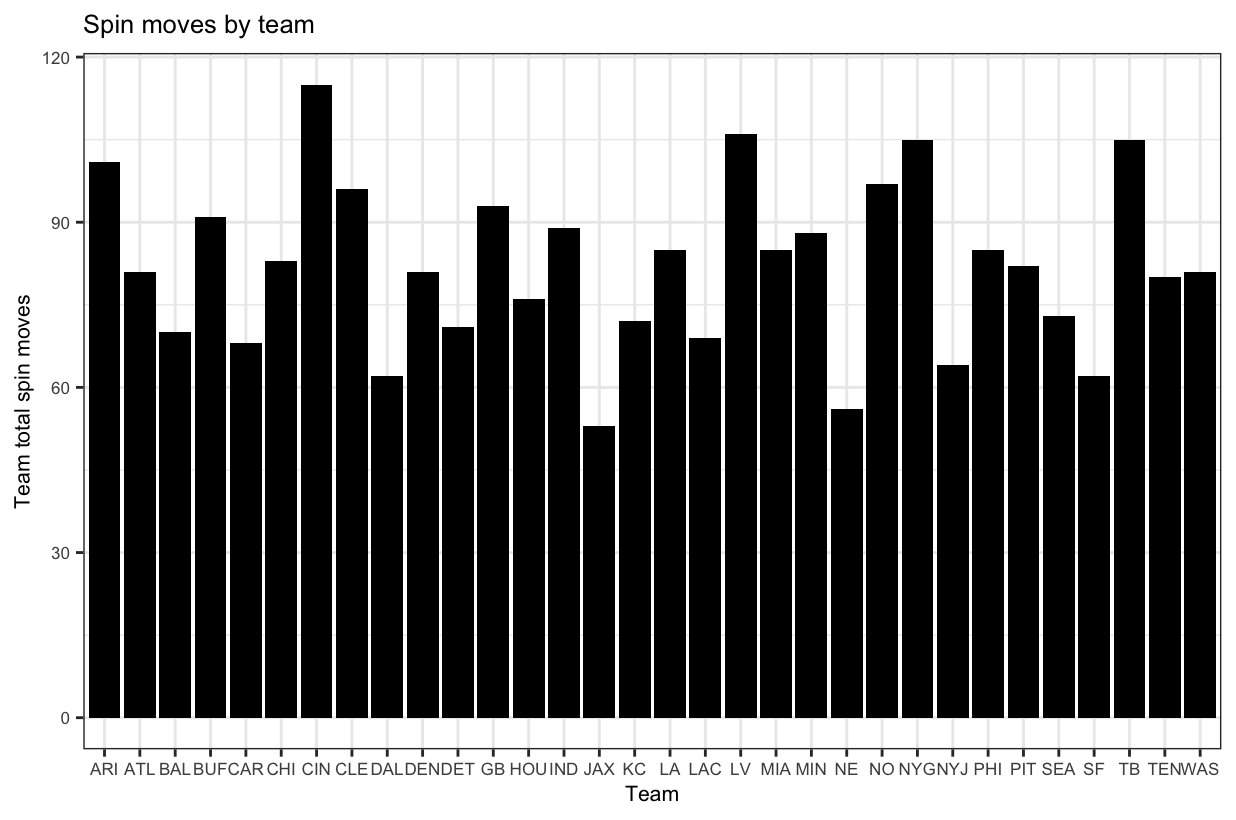

**Team spin count** *top 10 teams in bold

**ARI**
101

ATL
81

BAL
70

**BUF**
91

CAR
68

CHI
83

**CIN**
115

**CLE**
96

DAL
62

DEN
81

DET
71

**GB**
93

HOU
76

**IND**
89

JAX
53

KC
72

LA
85

LAC
69

**LV**
106

MIA
85

MIN
88

NE
56

**NO**
97

**NYG**
105

NYJ
64

PHI
85

PIT
82

SEA
73

SF
62

**TB**
105

TEN
80

WAS
81

In [ ]:
#total team pressures from spin moves
teampressurescore<- testsnap %>%
  group_by(team) %>%
  filter(spinmove==1) %>%
  summarize(total_score = sum(total_pressure))
view(teampressurescore)

testsnap %>%
  
  group_by(team) %>%
  filter(spinmove==1) %>%

  summarize(total_score = sum(total_pressure))  %>%
  
  ggplot(aes(as.character(team), total_score))+
  
  geom_bar(fill = "lightblue", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Team total pressure scores") +
  
  xlab("Team") +
  
  ggtitle("Spin move pressure by team")

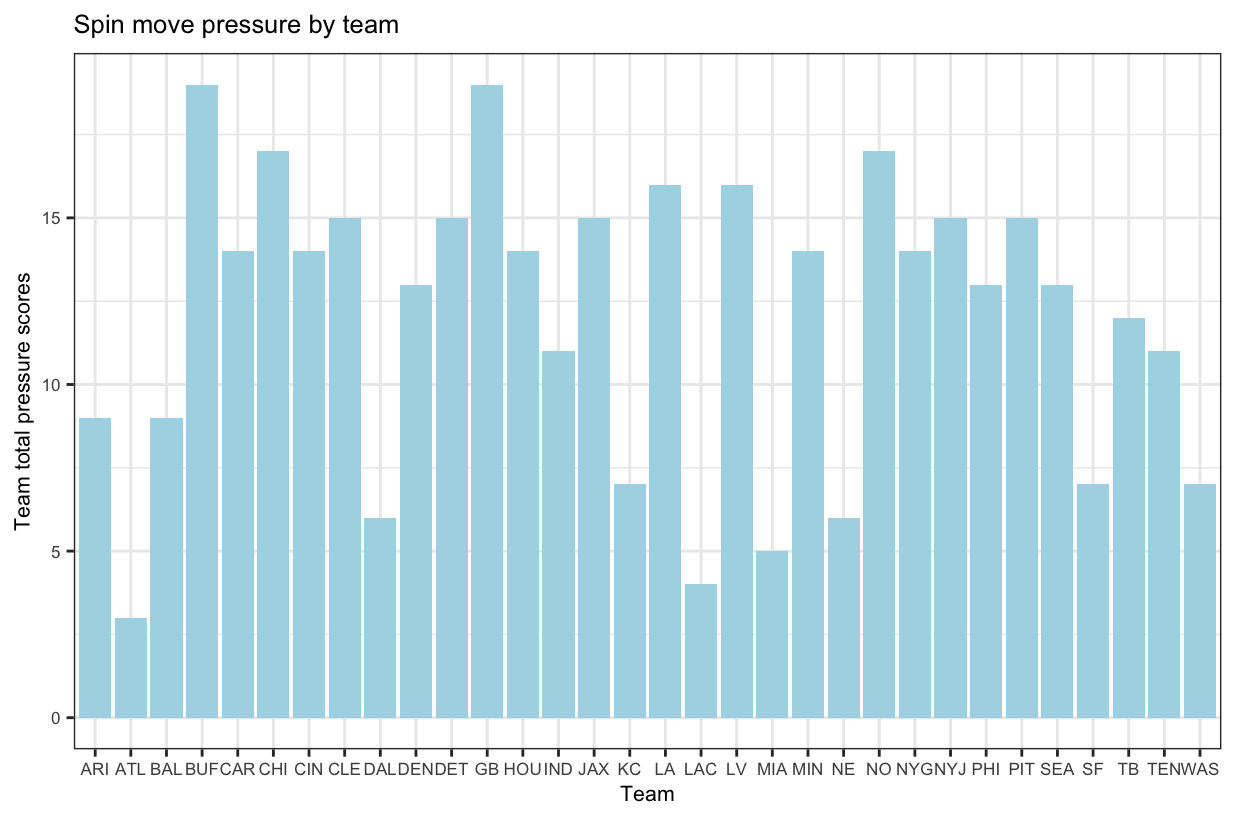

**Team total pressure score from spin moves** *top 10 in bold

ARI
9

ATL
3

BAL
9

**BUF**
19

CAR
14

**CHI**
17

CIN
14

**CLE**
15

DAL
6
1
DEN
13
1
DET
15
1
**GB**
19
1
HOU
14

IND
11

**JAX**
15

KC
7

**LA**
17

LAC
4

**LV**
16

MIA
5

MIN
14

NE
6

**NO**
17

NYG
14

**NYJ**
15

PHI
13

**PIT**
15

SEA
13

SF
7

TB
12

TEN
11

WAS
7

In [ ]:
model1 <- glm(total_pressure ~ spinmove +down + yardsToGo+scorediff,data=testsnap, family="binomial")
summary(model1)
Call:
glm(formula = total_pressure ~ spinmove + down + yardsToGo + 
    scorediff, family = "binomial", data = testsnap)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8411  -0.5600  -0.5133  -0.4814   2.3048  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.527007   0.034621 -72.991   <2e-16 ***
spinmove     0.104104   0.055969   1.860   0.0629 .  
down         0.234419   0.009652  24.287   <2e-16 ***
yardsToGo    0.025237   0.002092  12.061   <2e-16 ***
scorediff   -0.028154   0.011334  -2.484   0.0130 * 

**Model testing total pressure** 

spin move is not a signficant variable for pressure

as the down increases from 1 to 4 the odds of pressure increases
 
 spin move is not a significant variable for increasing chance of pressure

lining up on the outside position increases chance of pass rush

pass coverage formations of cover 0, 1,3,6 as well as goal line and red zone increase chance of pressure


In [ ]:
#model 2
model2<- glm(total_pressure ~ spinmove +down + yardsToGo+ pff_positionLinedUp+pff_passCoverage,data=testsnap, family="binomial")
Call:
glm(formula = total_pressure ~ spinmove + down + yardsToGo + 
    pff_positionLinedUp + pff_passCoverage, family = "binomial", 
    data = testsnap)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9265  -0.5691  -0.5097  -0.4420   2.4099  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -2.629864   0.065010 -40.454  < 2e-16 ***
spinmove                       0.061206   0.056175   1.090  0.27591    
down                           0.220804   0.009952  22.186  < 2e-16 ***
yardsToGo                      0.023049   0.002192  10.515  < 2e-16 ***
pff_positionLinedUpDRT        -0.066704   0.036979  -1.804  0.07126 .  
pff_positionLinedUpLE          0.224603   0.036721   6.116 9.57e-10 ***
pff_positionLinedUpLEO         0.486230   0.032796  14.826  < 2e-16 ***
pff_positionLinedUpLOLB        0.318654   0.033199   9.598  < 2e-16 ***
pff_positionLinedUpRE          0.212924   0.040770   5.223 1.76e-07 ***
pff_positionLinedUpREO         0.337315   0.034611   9.746  < 2e-16 ***
pff_positionLinedUpROLB        0.028077   0.035641   0.788  0.43082    
pff_passCoverageBracket       -0.097048   0.113700  -0.854  0.39336    
pff_passCoverageCover-0       -0.338201   0.072013  -4.696 2.65e-06 ***
pff_passCoverageCover-1       -0.128822   0.052340  -2.461  0.01385 *  
pff_passCoverageCover-2       -0.067903   0.054654  -1.242  0.21409    
pff_passCoverageCover-3       -0.126295   0.051822  -2.437  0.01481 *  
pff_passCoverageCover-6       -0.134109   0.057019  -2.352  0.01867 *  
pff_passCoverageGoal Line     -0.709023   0.172547  -4.109 3.97e-05 ***
pff_passCoverageMiscellaneous -0.545237   0.309221  -1.763  0.07786 .  
pff_passCoveragePrevent        0.065337   0.122820   0.532  0.59475    
pff_passCoverageQuarters      -0.041178   0.054924  -0.750  0.45342    
pff_passCoverageRed Zone       0.199467   0.061220   3.258  0.00112 ** 


**Model 2 testing total pressure**

spin move is not a significant variable for pressure
 
 as the down increases from 1 to 4 the odds of pressure increases
 
lining up on the outside position increases chance of pass rush

pass coverage formations of cover 0, 1,3,6 as well as goal line and red zone increase chance of pressure

In [ ]:
#spin moves by pass coverage

spindcov <- testsnap %>% 
  group_by(pff_passCoverage) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(spindcov)


testsnap %>%
  
  group_by(pff_passCoverage) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(pff_passCoverage), count))+
  
  geom_bar(fill = "blue", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Total spin moves") +
  
  xlab("pass coverage") +
  ggtitle("Spin moves by pass coverage")


**Spin Moves by pass coverage**

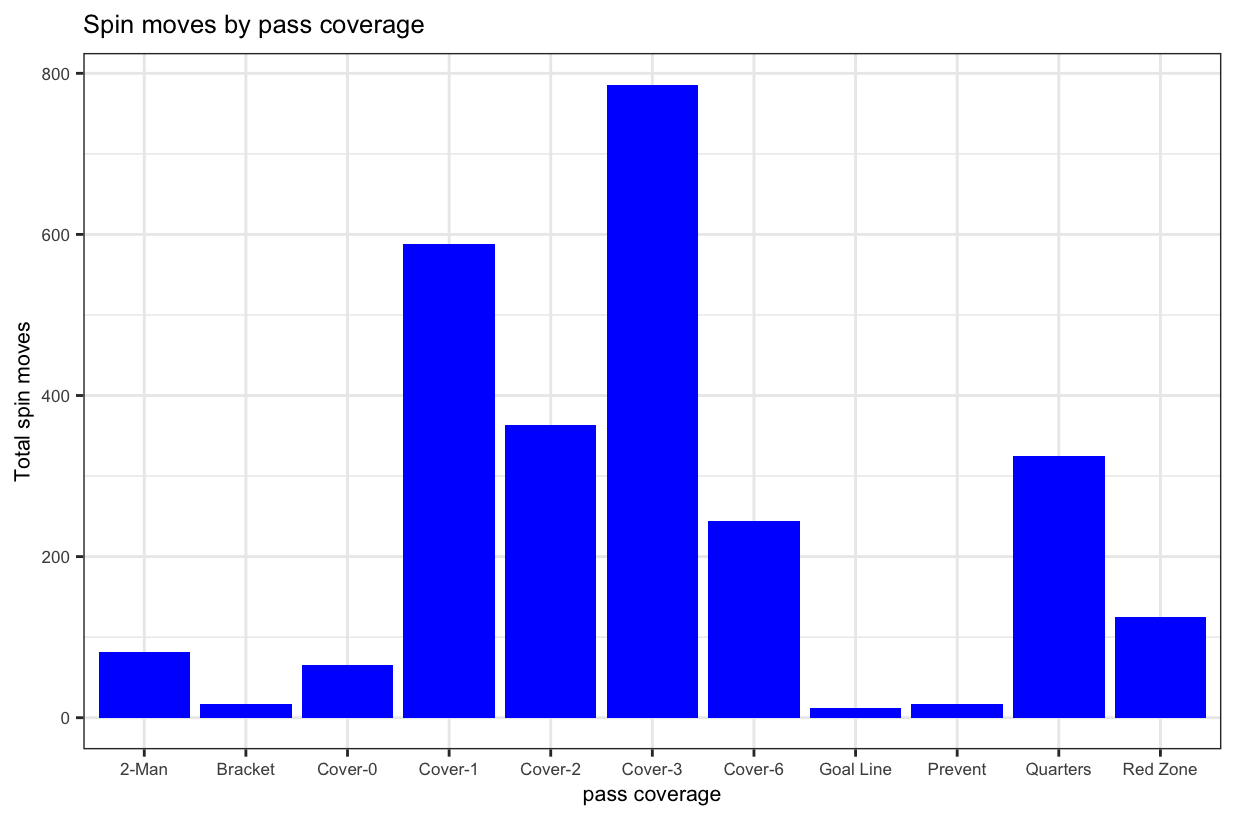



cover 3 and cover 1 the most common for spin moves. 



In [ ]:
#spin moves by offensive formation

testsnap %>%
  
  group_by(offenseFormation) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(offenseFormation), count))+
  
  geom_bar(fill = "lightblue", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Total spin moves per offensive formation") +
  
  xlab("Offensive formation") +
  
  ggtitle("Spin moves by offense formation")


**Spin move by offensive formation**

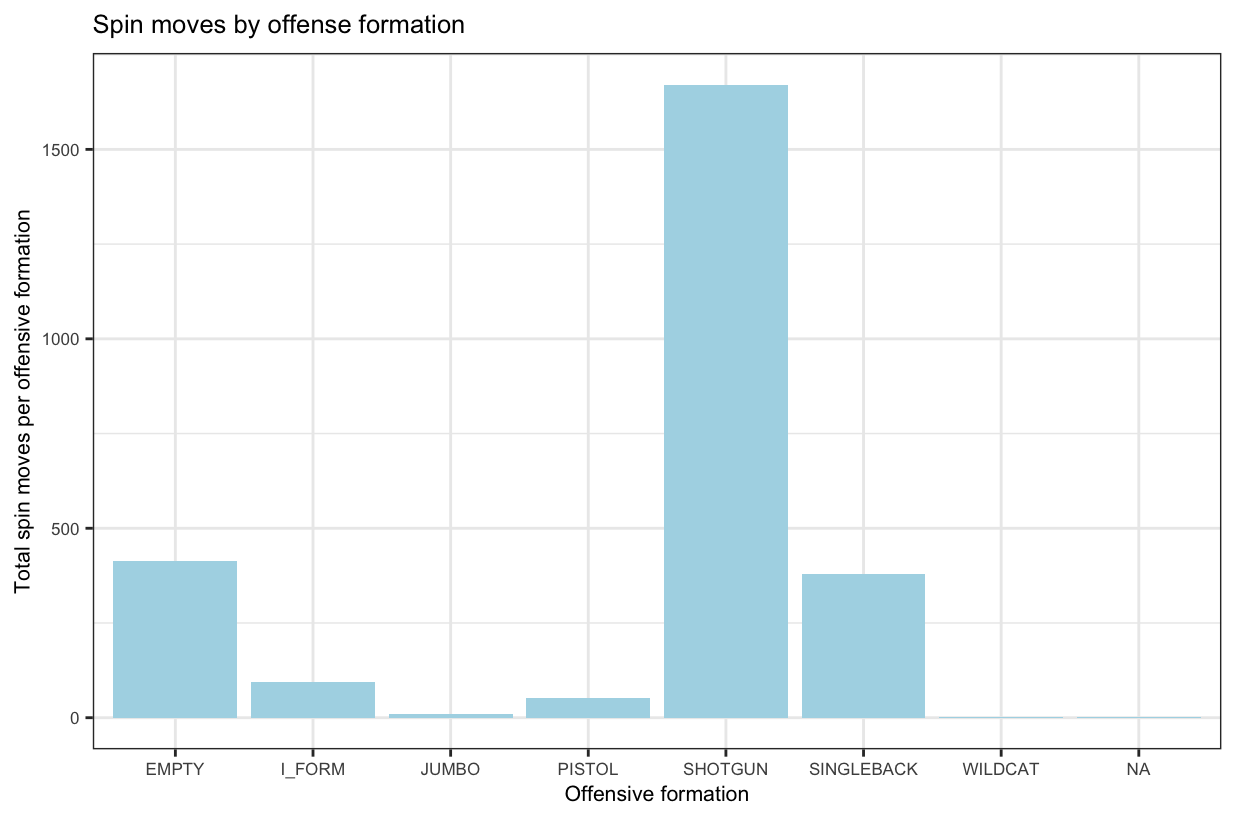



shotgun formations tend to lead to more spin moves then other formations as well as being the most common offense formation 

This may be because shotgun tends to be more passing and QB being further away creates more time for spin moves to develop.

In [ ]:
#spinmoves by down
spinbydown <- testsnap %>% 
  group_by(down) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(spinbydown)

testsnap %>%
  
  group_by(down) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(down), count))+
  
  geom_bar(fill = "lightblue", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Total spin moves") +
  
  xlab("Down") +
  
  ggtitle("Spin moves by Down")


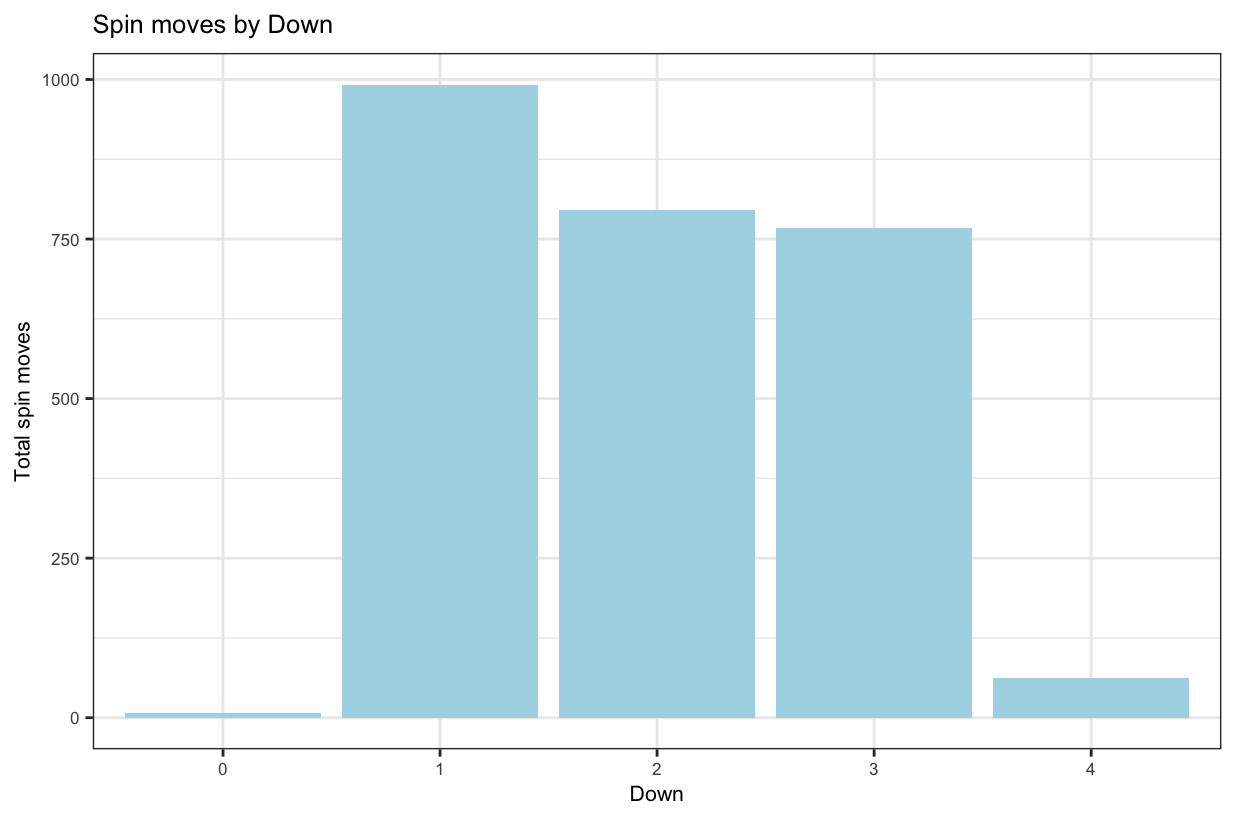

first down the most common down for spinmove in passing situations while second and third are close to same amount. 



In [ ]:
#spinmoves by yards to go
spinbyytg <- testsnap %>% 
  group_by(yardsToGo) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(spinbyytg)


**Spin moves by yards to go table**


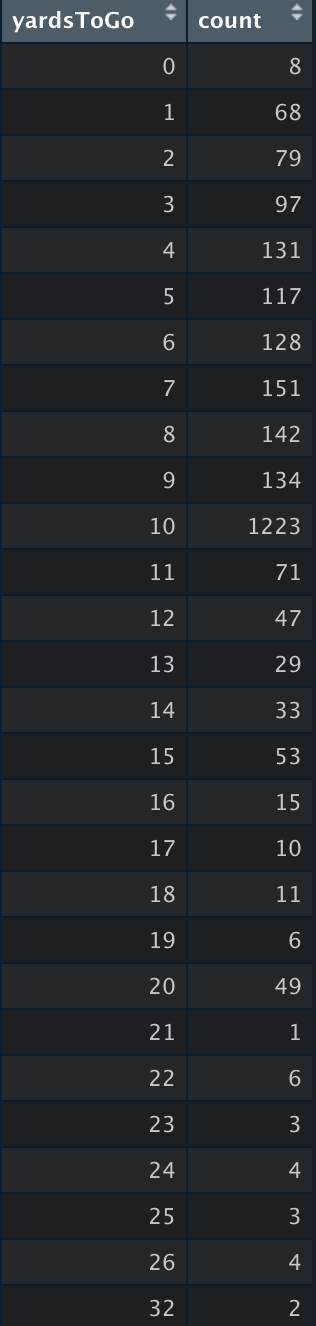

In [ ]:
#adding a column that gives score difference in the game. 
testsnap<-testsnap %>% 
  group_by(gameId, playId,nflId) %>%
  mutate(scorediff= ifelse(preSnapHomeScore > preSnapVisitorScore,2,0)+ifelse(preSnapHomeScore==preSnapVisitorScore,0,0)+ifelse(preSnapVisitorScore>preSnapHomeScore, 1, 0))

# spin moves by score #0=tie 1= visiting team is winning, 2=home team is winning
homescoretype <- testsnap %>% 
  group_by(scorediff) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(homescoretype)


After making a score differental column that says what team is winning home(2), visitor(1) or tie(0) 

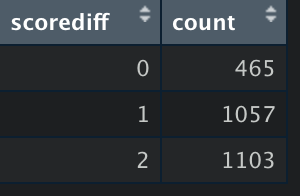

In [ ]:
# Pass Results
testsnap %>%
  
  group_by(passResult) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(passResult), count))+
  
  geom_bar(fill = "green", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Total spin moves") +
  
  xlab("passResult") +
  
  ggtitle("Spin moves by pass result")

passresult<-testsnap %>%
  
  group_by(passResult) %>%
  filter(spinmove==1) %>%
  summarize(count=n())
view(passresult)

#pass results combined with spin moves that though there is more completed passes then other outcomes, 45% passes were completed vs 55% other 4 more defensive positive outcomes

25 +66 + 267+ 277
#[1] 1435
 1190/(1190+1435)
#[1] 0.4533333

#pass results combined with spin moves that though there is more completed passes then other outcomes, 45% passes were completed vs 55% other 4 more defensive positive outcomes

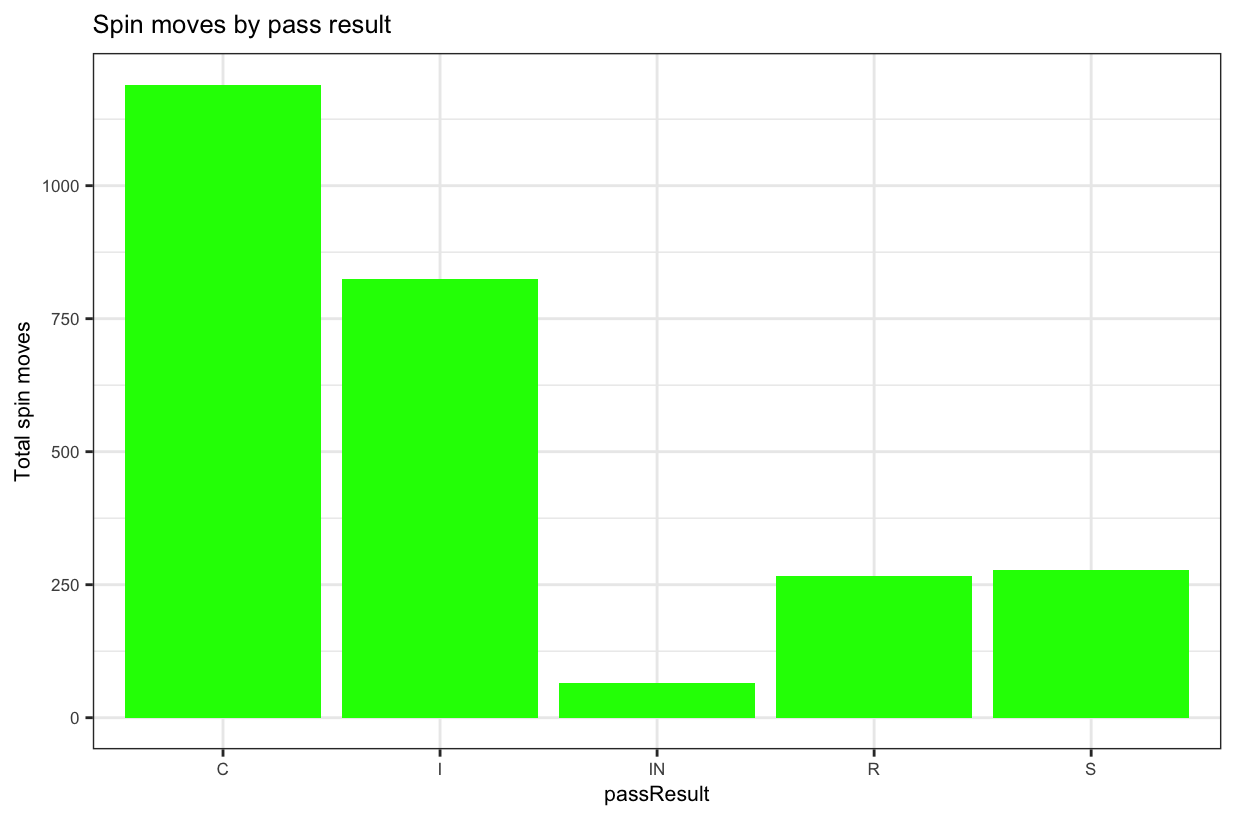

In [ ]:
# Spin move frequency by player position
testsnap %>%
  
  group_by(pff_positionLinedUp) %>%
  filter(spinmove==1) %>%
  summarize(count=n()) %>%
  
  ggplot(aes(as.character(pff_positionLinedUp), count))+
  
  geom_bar(fill = "grey", stat = "identity") +
  
  theme_bw()  +
  
  theme(text = element_text(size = 8)) +
  
  ylab("Total spin moves") +
  
  xlab("player position") +
  ggtitle("Spin moves by player position")

**Spin Moves by Position **
Outside edge rushers provided the most spin moves

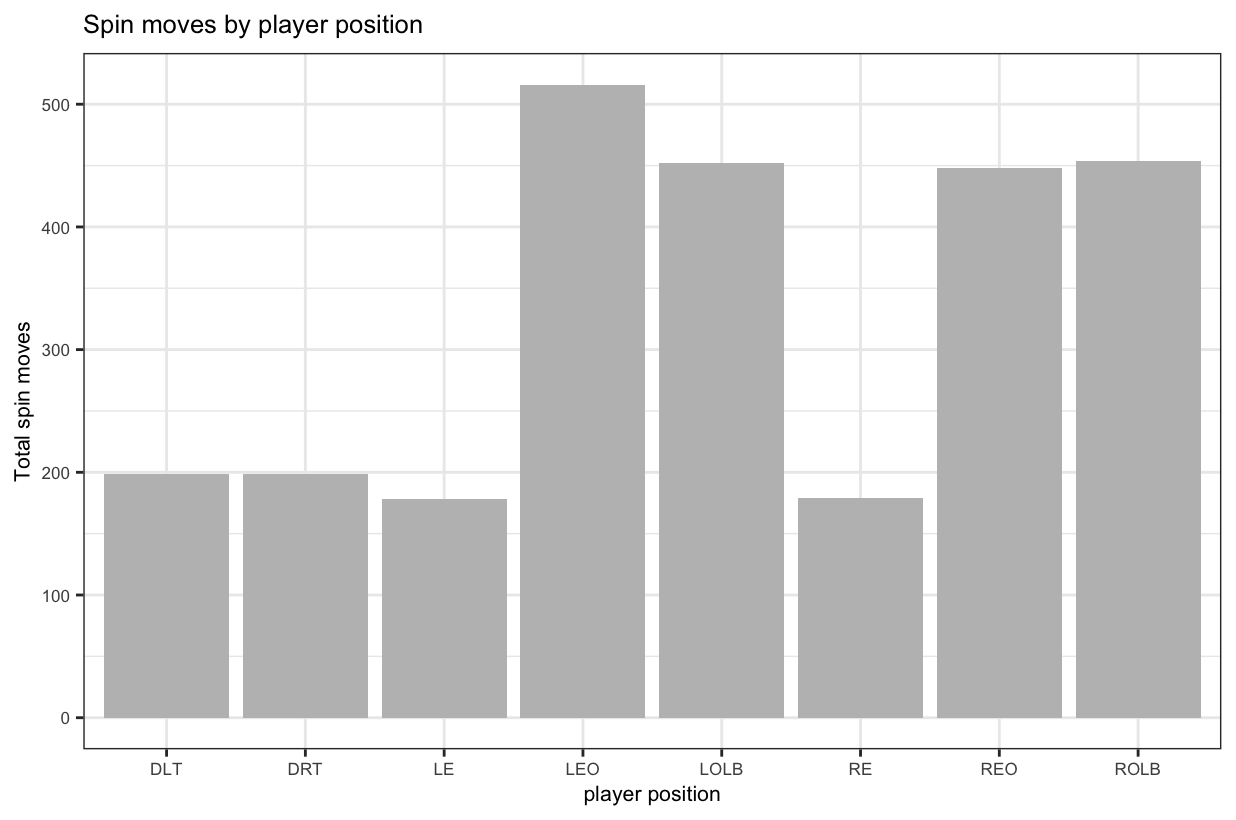

Findings summary: 

spin moves though not the most common pass rush  move provides opportunities for pass rusher to cause pressure espcially when their an edge rusher
spin moves though not nearly as recurring as other moves shows efficient causing slightly more pressure then other moves
#pass rushers that use spin moves in their arsenal most often are Yannick Ngakoue, Azeez Ojulari, Trey Hendrickson, Emmanuel Ogbah, Cameron Jordan, Sam Hubbard and T.J. Watt 
when spin moves occur pass plays tend to be effected with result of only 45% pass completions.
spin moves are not a significant factor when determine total pressure 


Limitations: 

label of what makes a spin move maybe off and misclassify player movement
lack of film to confirm spin move occurrence
players with with loop around edge rushes or spins caused by running into a teammate,
QB roll out plays,
time,
coding skills,
knowledge of the tracking data

Future of the project 
I plan on contiunting to refine and explore the data to create a more accurate spin move label as well as work on finding way to label other pass rush moves like swim move. Continue to improve R and coding skills for more complete analysis and new discoveries. Cool idea would be able to see over years changes in number of spin moves by the league and specifc players.